In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import gc

In [2]:
import multipy

In [3]:
from tqdm import tqdm

In [4]:
import seaborn as sns

In [5]:
[x for x in os.listdir(os.getcwd()) if "coli" in x]

['e_coli_O157.fasta', 'methylationout_E_coli.csv']

In [6]:
df = pd.read_csv("fichier_eric_methylationoutColi_all_A_all_coverages.csv",sep=";")

In [7]:
df["logipdRatio"] = [np.log(x) for x in df["ipdRatio"]]

In [8]:
len(df)

832847

In [9]:
df["logipdRatio"] = [np.log(x) for x in df["ipdRatio"]]

In [10]:
t2 = pd.read_csv("./methylationout_E_coli.csv")

In [11]:
len(t2)

3339458

In [12]:
t2 = t2[t2["base"] == "A"]

In [13]:
len(t2)

832847

In [14]:
df = df[(df["base"] == "A")]

In [15]:
len(df)

832847

In [16]:
df = df.sort_values(["experiment","HoleID","tpl","strand"],ascending=True)
t2 = t2.sort_values(["experiment","HoleID","tpl","strand"],ascending=True)

In [17]:
t2["pvalue"].isnull().value_counts()

False    832847
Name: pvalue, dtype: int64

In [18]:
df["score"].isnull().value_counts()

False    832847
Name: score, dtype: int64

In [19]:
df["pvalue"] = [x for x in t2["pvalue"].values]

In [20]:
df["pvalue"].isnull().value_counts()

False    832847
Name: pvalue, dtype: int64

In [21]:
del t2
gc.collect()

0

In [22]:
df["isin_GATC"] = df["context"].str[19:23] == "GATC"

In [23]:
def recognize_GCaCNNNNNNGTT(context):
    if context[18:22] == "GCAC":
        if context[28:31] == "GTT":
            return True
    
    return False

In [24]:
# Now the third modification
def recognize_AaCNNNNNNGTGC(context):
    if context[19:22] == "AAC":
        if context[28:32] == "GTGC":
            return True
    return False

In [25]:
df["ecoK_type1"] = [recognize_GCaCNNNNNNGTT(x) for x in tqdm(df["context"])]

100%|██████████| 832847/832847 [00:00<00:00, 1927316.79it/s]


In [26]:
df["ecoK_type2"] = [recognize_AaCNNNNNNGTGC(x) for x in tqdm(df["context"])]

100%|██████████| 832847/832847 [00:00<00:00, 1904940.66it/s]


In [27]:
df["ecoK"] = [x or y for (x,y) in zip(df["ecoK_type1"],df["ecoK_type1"])]

In [28]:
df.loc[df["ecoK_type1"],"motif"] = "AaC(6N)GTGC"
df.loc[df["ecoK_type2"],"motif"] = "GCaC(6N)GTT"
df.loc[df["isin_GATC"],"motif"] = "GATC"
df.loc[df["motif"].isnull(),"motif"] = "other"

In [29]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 22})

In [30]:
intervals = [15,25,30,50,1000]
coverage_categories = np.searchsorted(intervals, df["coverage"], side='left')
coverage_category_map = {
    0:"0-15",
    1:"15-25",
    2:"25-30",
    3:"30-50",
    4:">50"
}
df["coverage category"] = [coverage_category_map[x] for x in coverage_categories]

In [31]:
df["coverage category"].value_counts(normalize=True)

>50      0.399420
30-50    0.216879
0-15     0.206716
15-25    0.125009
25-30    0.051976
Name: coverage category, dtype: float64

In [32]:
df["motifbis"] = ["Probabily non methylated" if x=="other" else "Probably methylated" for x in df["motif"]]

In [33]:
for (covcat, motif), tmp in df.groupby(["coverage category","motifbis"]):
    print(covcat,motif)

0-15 Probabily non methylated
0-15 Probably methylated
15-25 Probabily non methylated
15-25 Probably methylated
25-30 Probabily non methylated
25-30 Probably methylated
30-50 Probabily non methylated
30-50 Probably methylated
>50 Probabily non methylated
>50 Probably methylated


In [34]:
palette = {
    'other': 'tab:purple',
    'GATC': 'tab:green',
    'AaC(6N)GTGC': 'tab:blue',
    'GCaC(6N)GTT': 'tab:red',
}

In [35]:
palette_multikde = {
    "0-15":"red",
    "15-25":"blue",
    "25-30":"green",
    "30-50":"purple",
    ">50":"brown"
}

In [36]:
from scipy.stats import gaussian_kde

In [37]:
plt.rcParams["figure.figsize"] = (20,15)

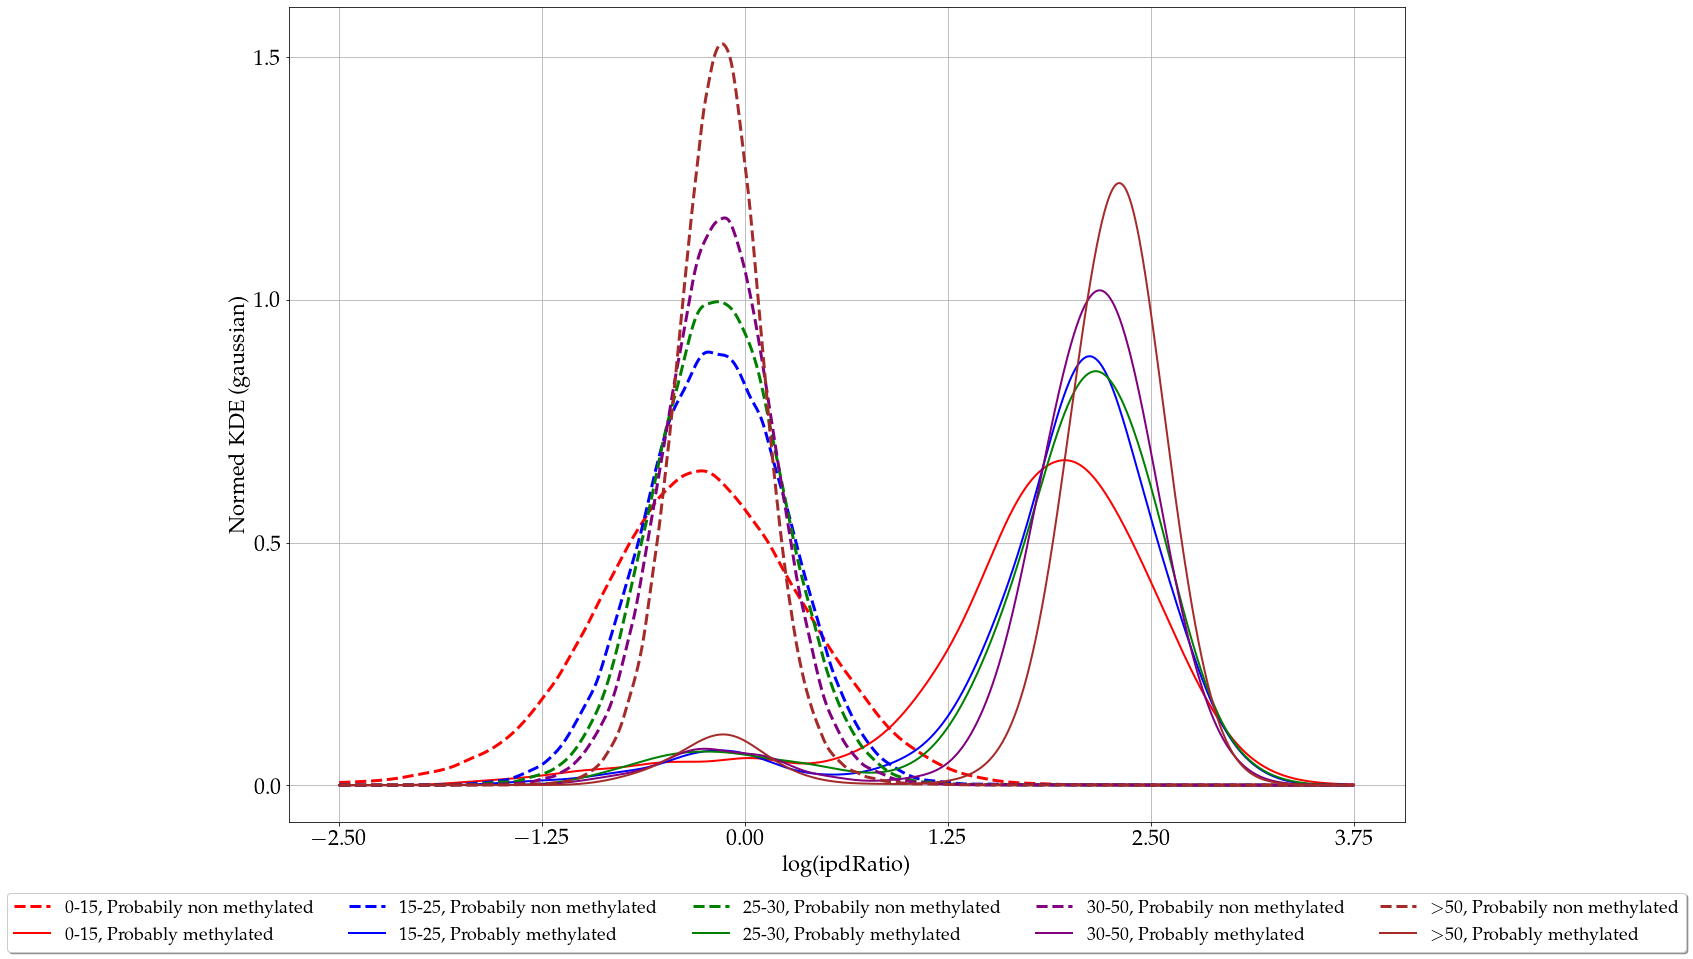

In [38]:
for (covcat, motif), tmp in df.groupby(["coverage category","motifbis"]):

    if motif != "Probably methylated":
        linestyle = "--"
        linewidth = 3
    else:
        linestyle = "-"
        linewidth = 2
    
    x = np.linspace(-2.5,3.75,1000)
    kde = gaussian_kde(tmp["logipdRatio"])
    plt.plot(x,
             kde.pdf(x),
             linestyle = linestyle,
             color=palette_multikde[covcat],
             linewidth=linewidth,
             label="{}, {}".format(covcat.replace(">","$>$"),motif)
            )
    
plt.xticks([-2.5,-1.25,0,1.25,2.5,3.75])
plt.yticks([0,0.5,1,1.5])
plt.legend(loc="lower center",bbox_to_anchor=(0.5, -0.17),
           prop={"size":18},ncol=5,shadow=True)
plt.xlabel("log(ipdRatio) ")
plt.ylabel("Normed KDE (gaussian)")
plt.grid()
plt.savefig("ipdratio_distrib_effect_coverage.pdf")
plt.show()

In [38]:
# Removing adenines with insufficient coverage now
df = df[(df["coverage"] >= 25)]

In [39]:
df.groupby(["experiment"]).apply(lambda x: len(x["uniqueID"].unique()))

experiment
HT2           1
HTVEG       942
MAB         493
MT1A1B     1147
MT1A1B2     224
MT2         171
NM4         477
NM4910      141
NM910       359
dtype: int64

In [40]:
np.sum(df.groupby(["experiment"]).apply(lambda x: len(x["uniqueID"].unique())).values)

3955

In [41]:
df.groupby(["experiment"]).apply(lambda x: len(x))

experiment
HT2           286
HTVEG      155447
MAB         66135
MT1A1B     155838
MT1A1B2     30558
MT2         23526
NM4         64488
NM4910      22214
NM910       48661
dtype: int64

In [42]:
df["motif"].value_counts()

other          557245
GATC             9656
GCaC(6N)GTT       127
AaC(6N)GTGC       125
Name: motif, dtype: int64

In [43]:
motifs = ["GATC", "AaC(6N)GTGC","GCaC(6N)GTT","other"]

In [44]:
np.sum(df.groupby(["experiment"]).apply(lambda x: len(x)).values)

567153

In [45]:
a=80/115
b=20-15*(80/115)
# df["y"] = a*df["coverage"]+b
# df["isover_linear"] =df["score"] > df["y"] 
# df

In [46]:
a

0.6956521739130435

In [47]:
b

9.565217391304348

In [45]:
plt.rcParams["figure.figsize"] = (20,20)

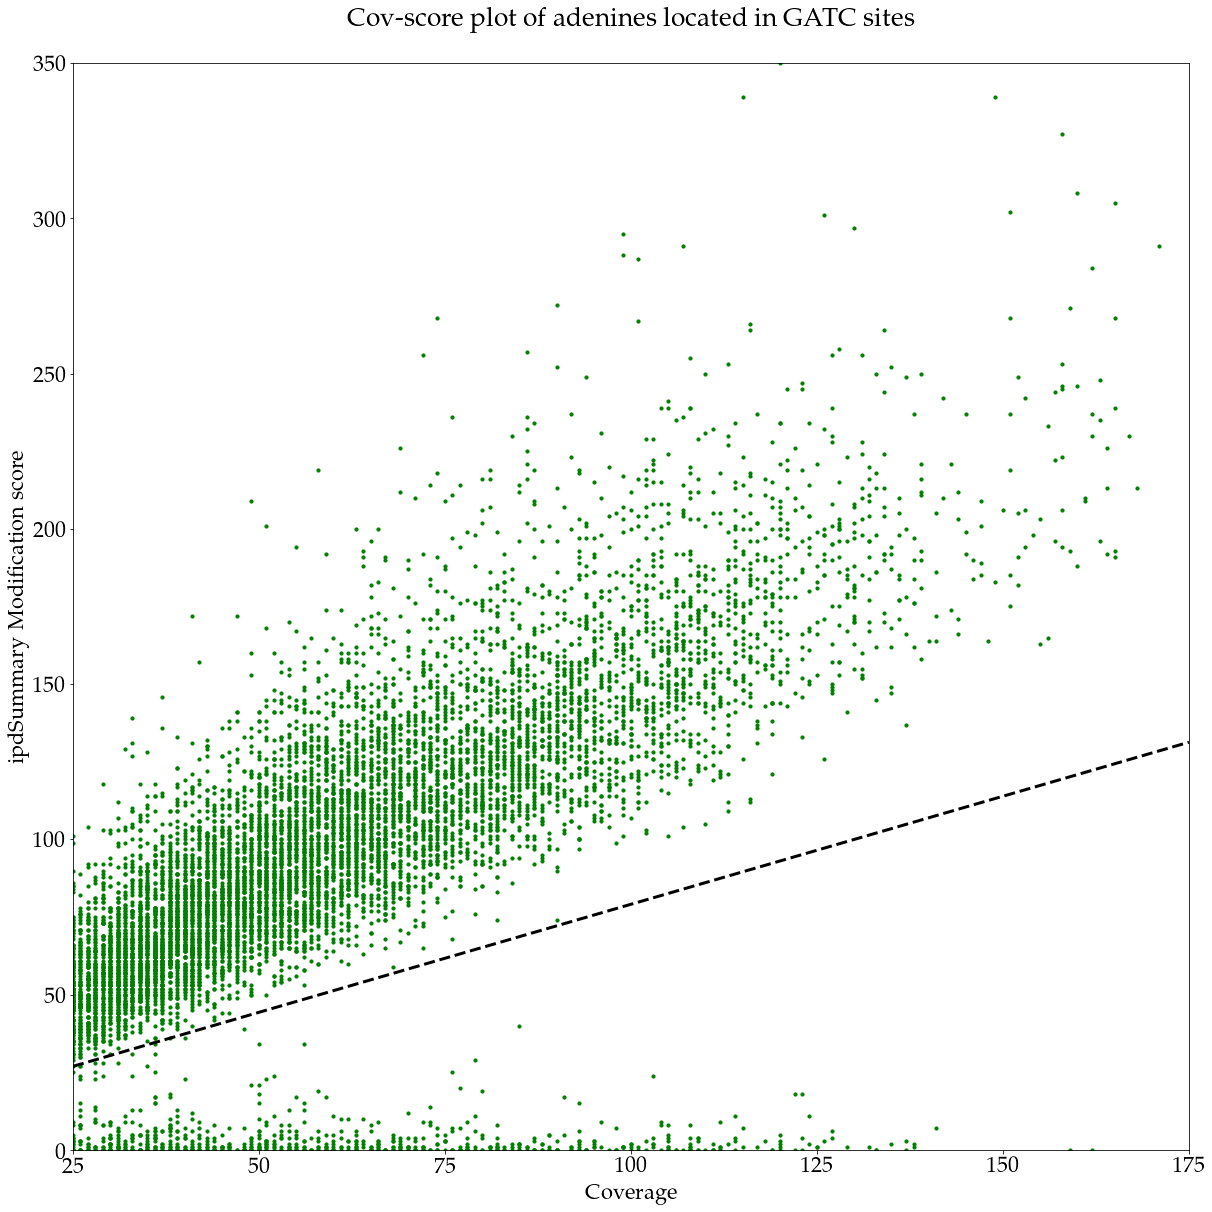

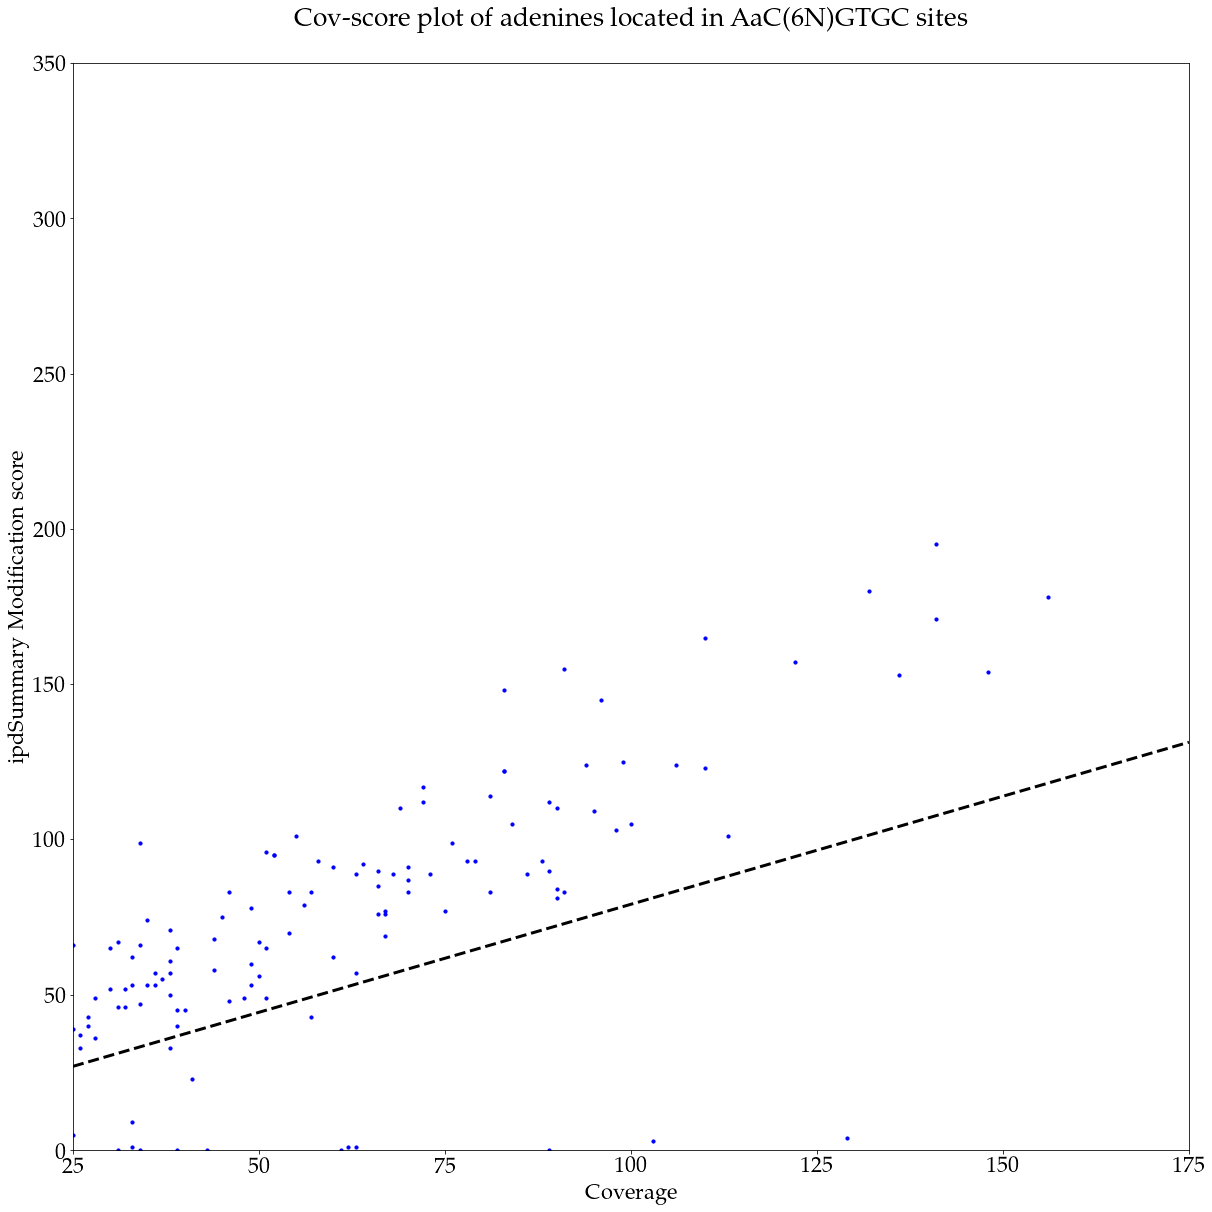

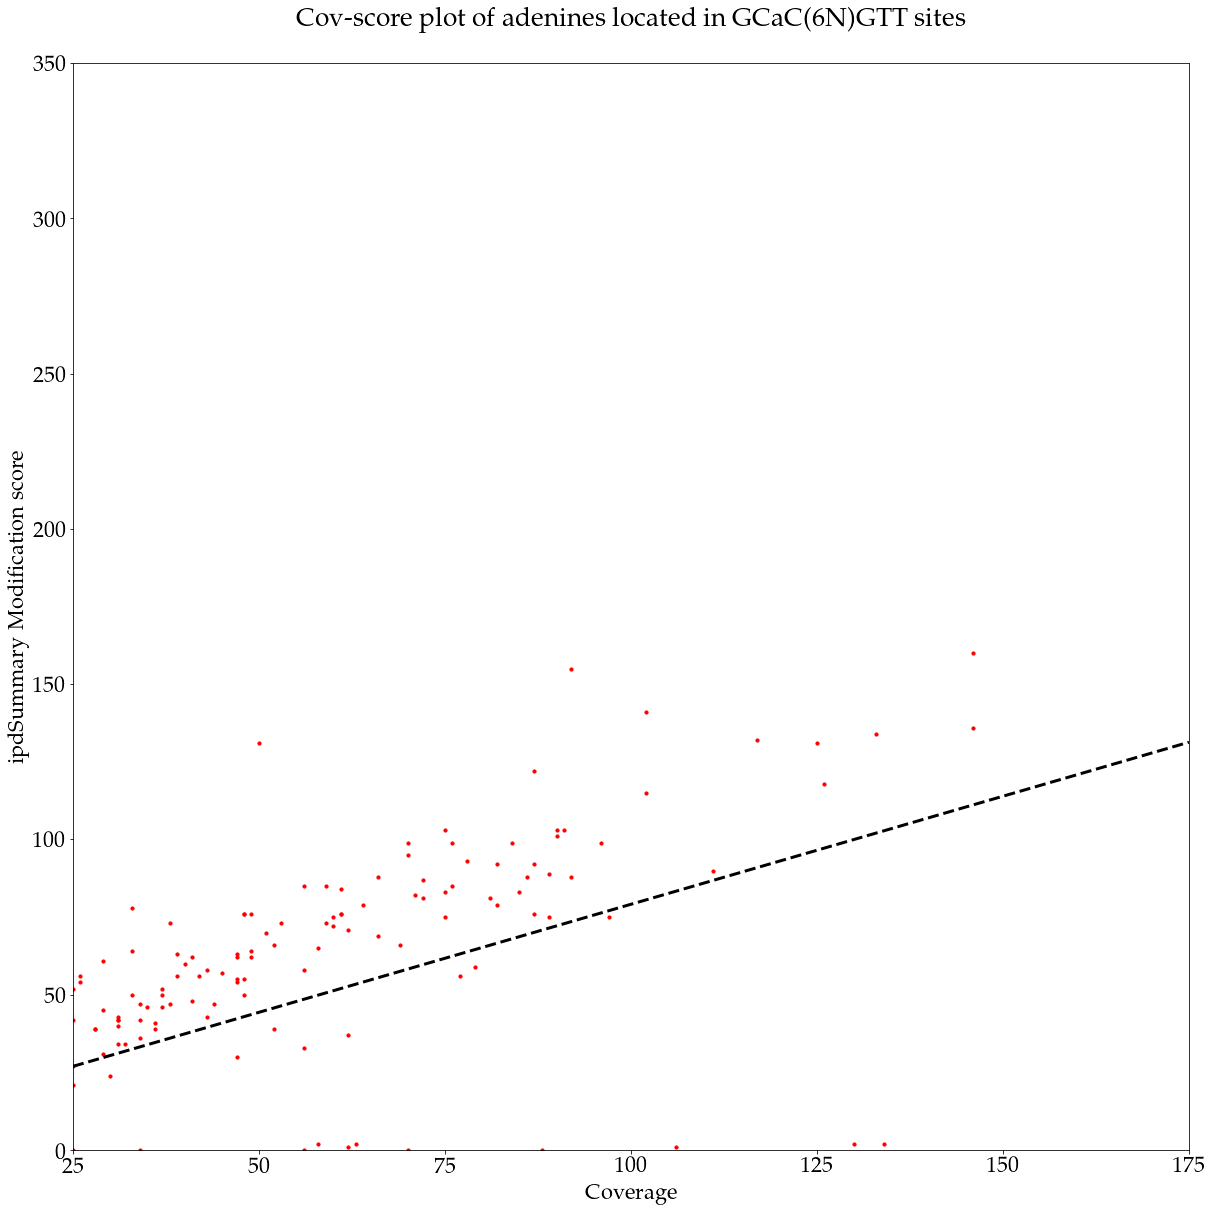

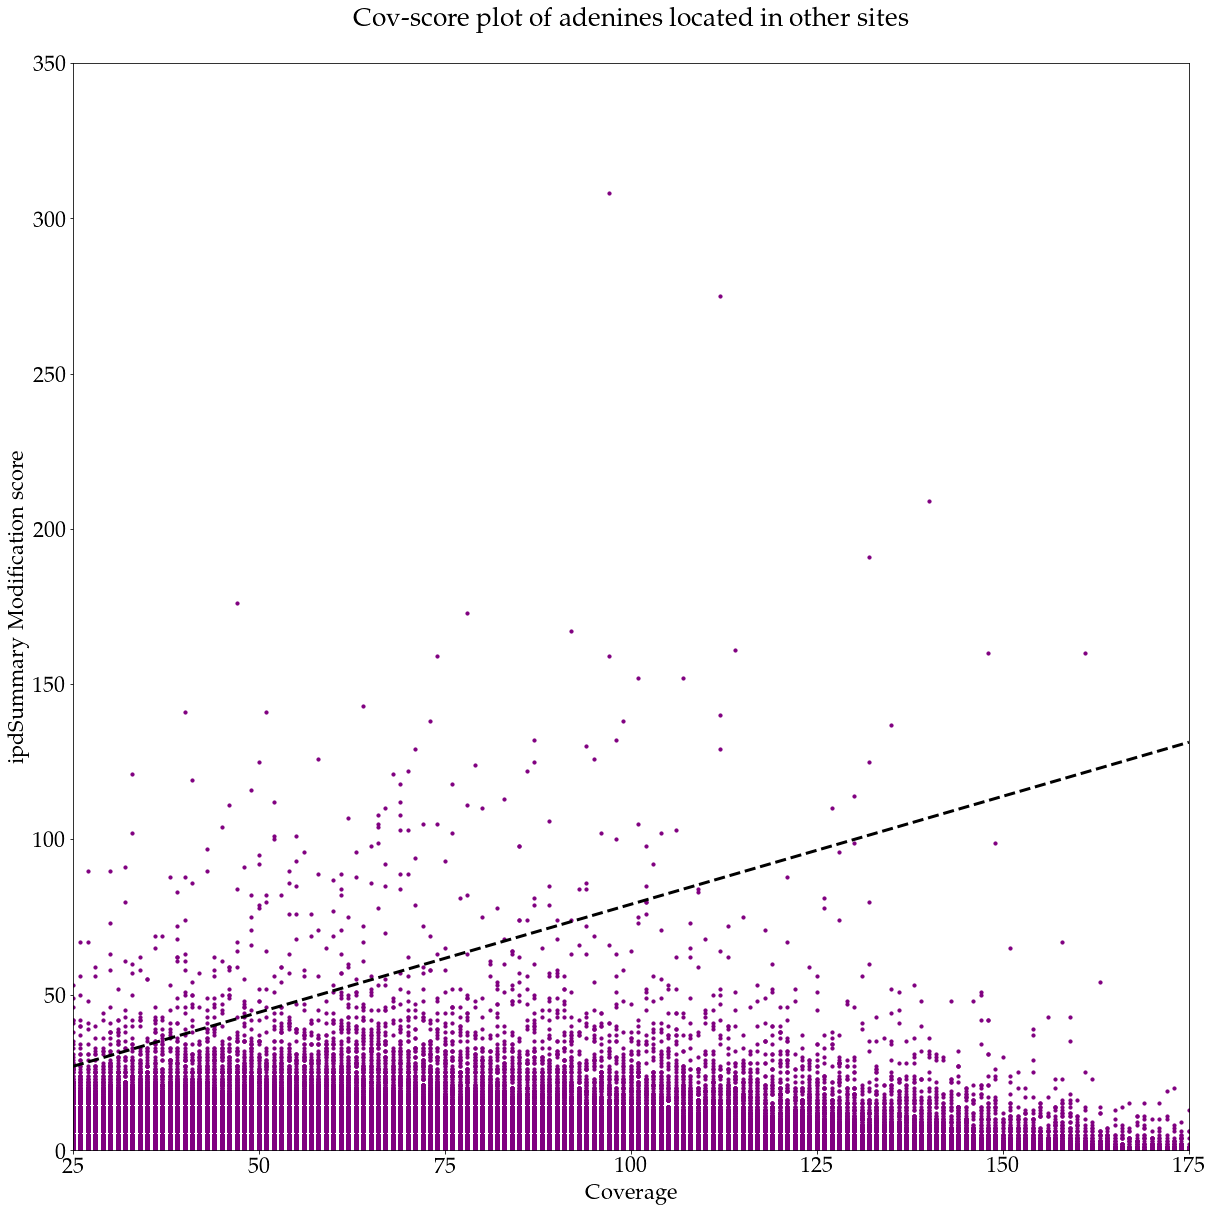

In [49]:
xlinear1 = 0
xlinear2 = 175
ylinear1 = a*xlinear1 + b
ylinear2 = a*xlinear2 + b

motifs = ["GATC", "AaC(6N)GTGC","GCaC(6N)GTT","other"]
colors = ["green","blue","red","purple"]
# n = len(motifs)
# colors = iter(plt.cm.rainbow(np.linspace(0, 1, n)))

for motif,color in zip(motifs,colors):
    tmp = df[df["motif"] == motif]
    plt.scatter(tmp["coverage"],tmp["score"],s=10,label=motif,color=color)
    plt.axline((xlinear1,ylinear1), (xlinear2, ylinear2), linewidth=3, color='black',label="proposed threshold",linestyle="--")
#     plt.legend(loc="upper right")
    plt.xlim((25,175))
    plt.ylim((0,350))
    plt.xlabel("Coverage")
    plt.ylabel("ipdSummary Modification score")
    plt.title("Cov-score plot of adenines located in {} sites \n".format(motif))
    
    titlefig = "covscore_{}".format(motif)
    
    plt.xticks([x for x in range(25,200,25)])
    
    plt.savefig(titlefig+".pdf")
    
    plt.show()



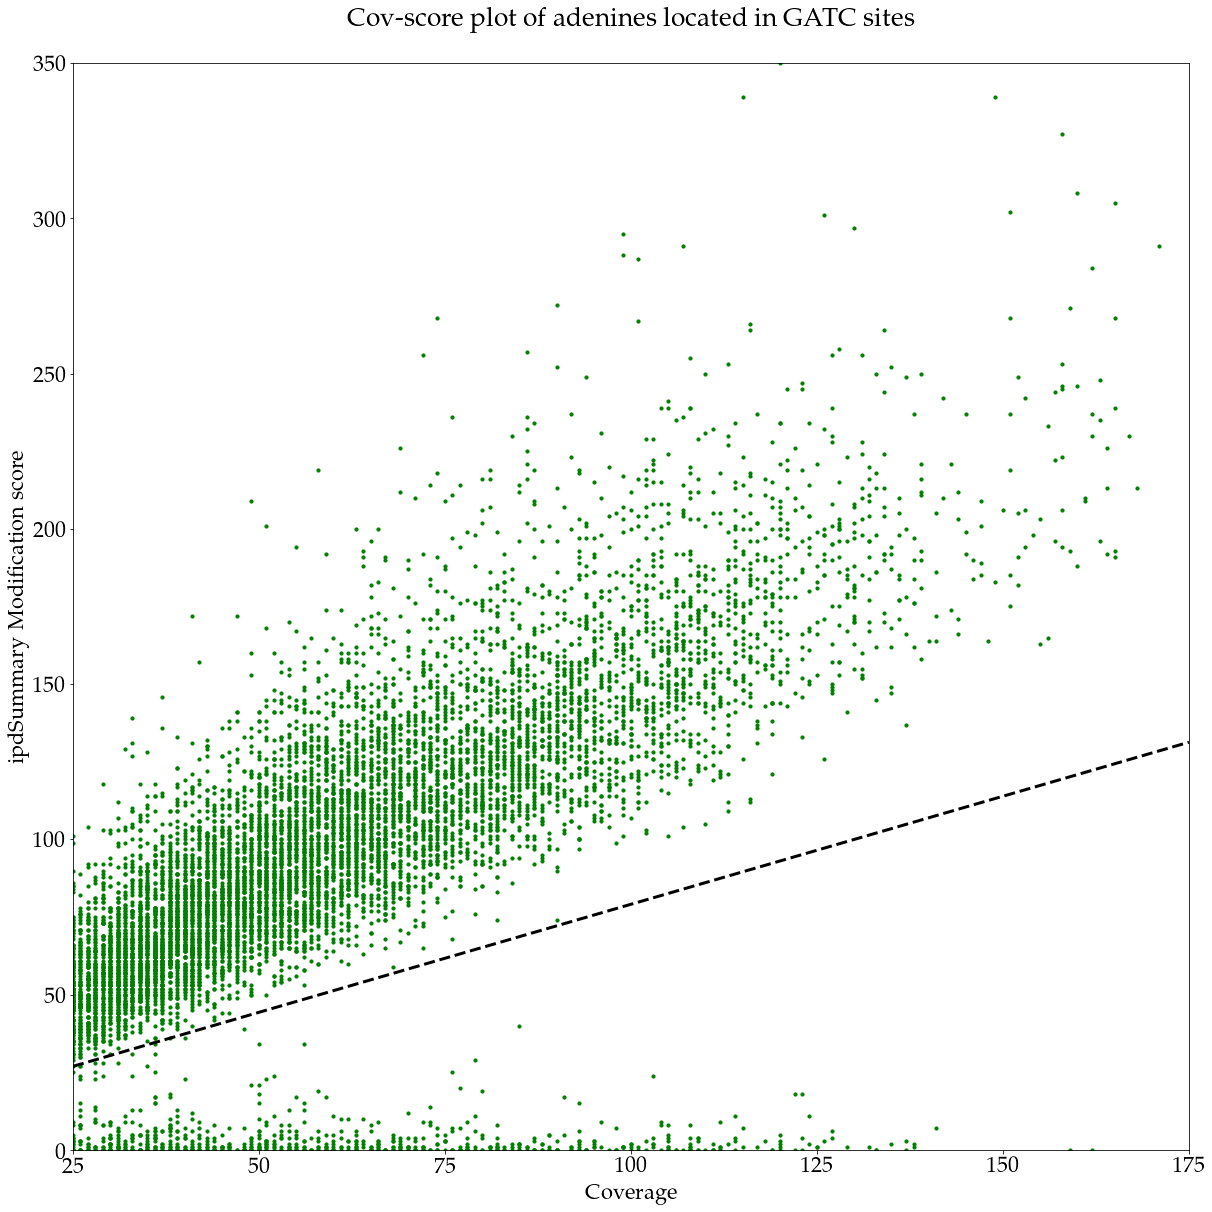

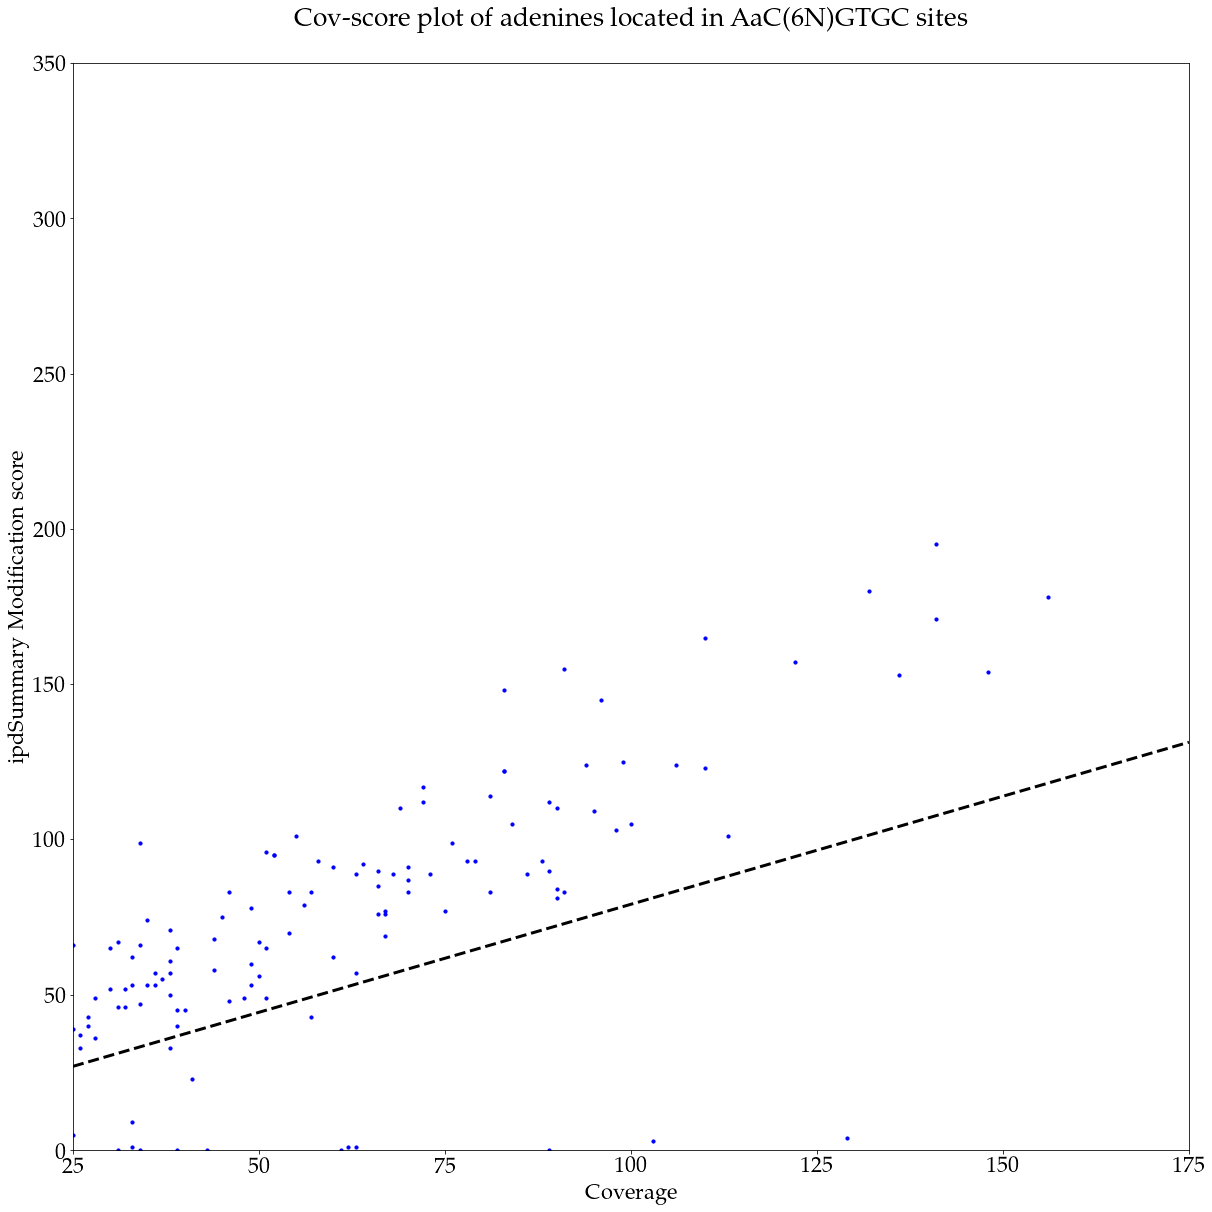

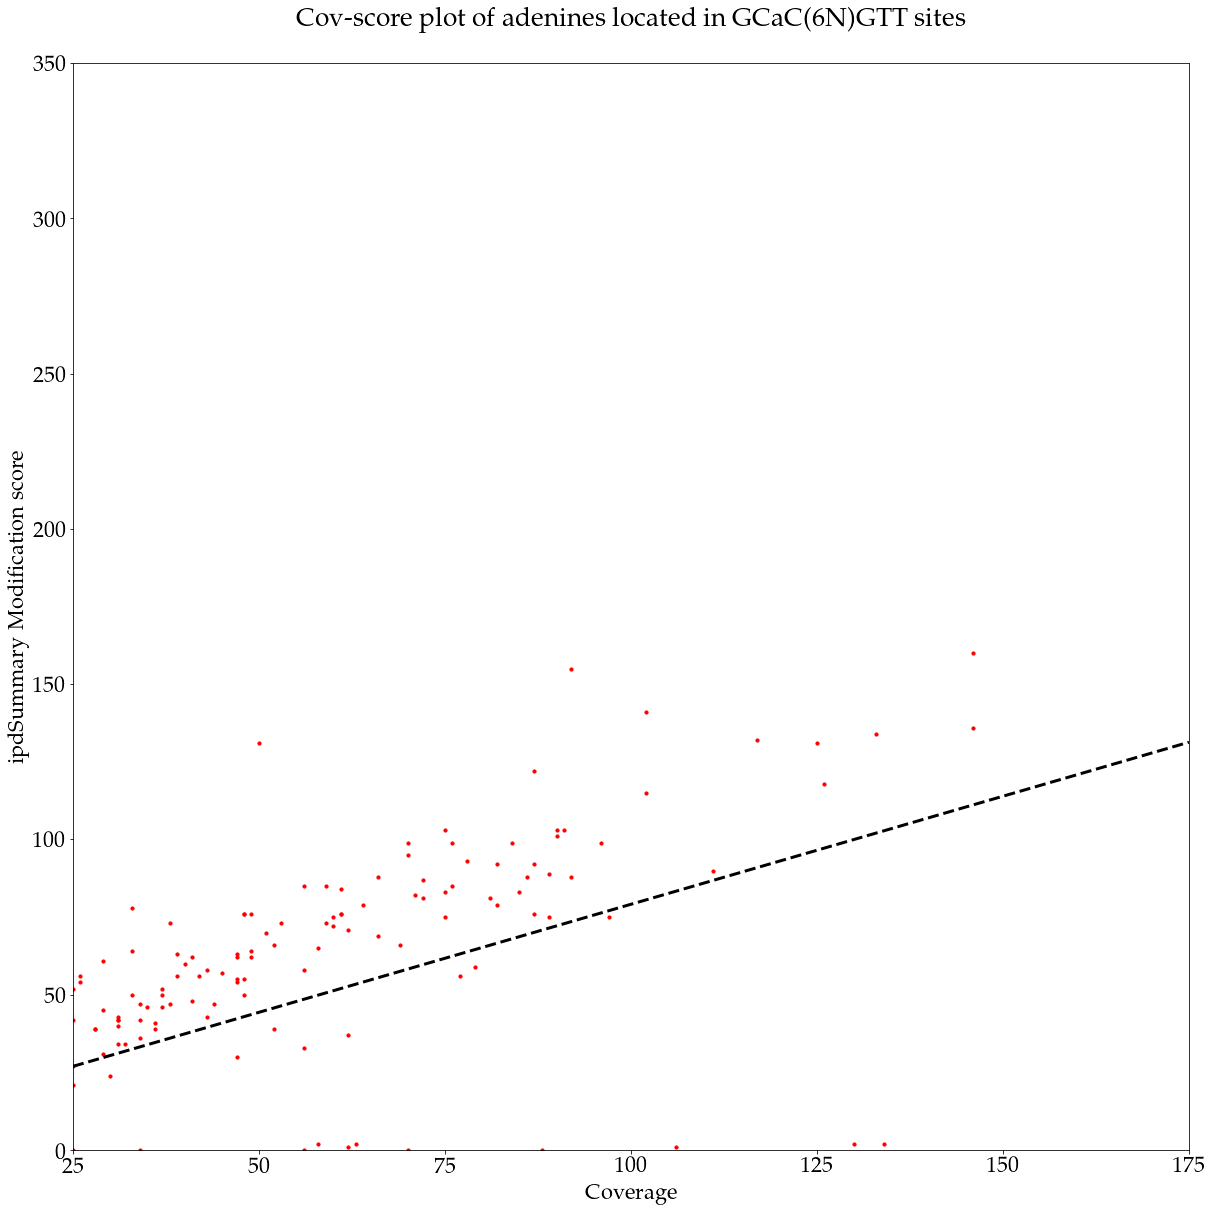

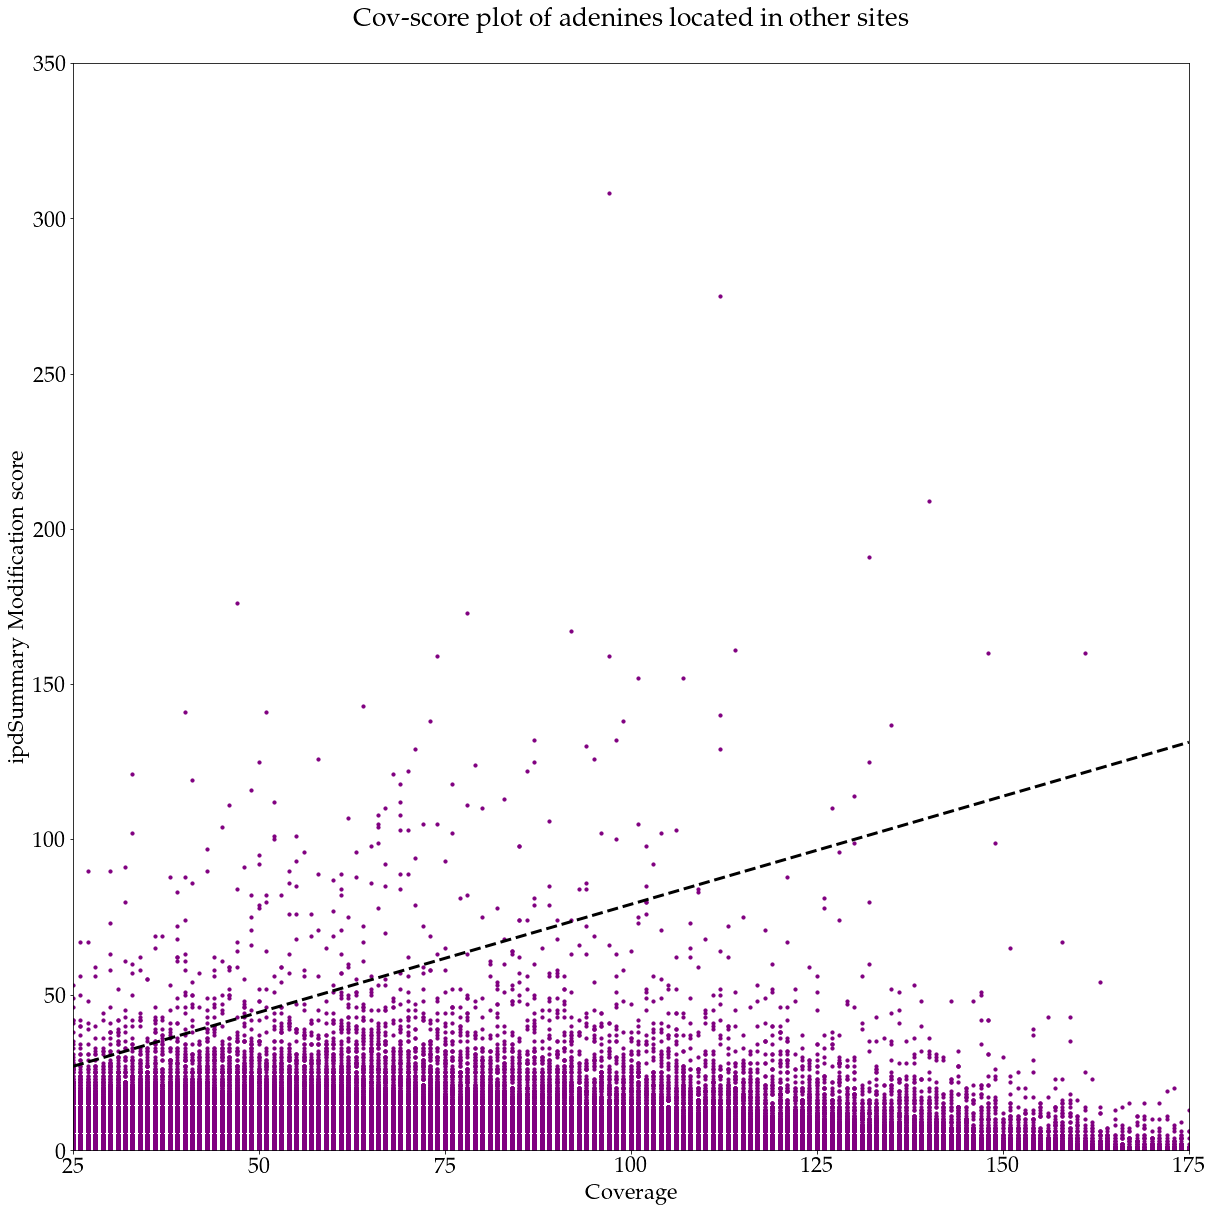

In [50]:
xlinear1 = 0
xlinear2 = 175
ylinear1 = a*xlinear1 + b
ylinear2 = a*xlinear2 + b

motifs = ["GATC", "AaC(6N)GTGC","GCaC(6N)GTT","other"]
colors = ["green","blue","red","purple"]


for motif,color in zip(motifs,colors):
    tmp = df[df["motif"] == motif]
    plt.scatter(tmp["coverage"],tmp["score"],s=10,label=motif,color=color)
    plt.axline((xlinear1,ylinear1), (xlinear2, ylinear2), linewidth=3, color='black',label="proposed threshold",linestyle="--")
#     plt.legend(loc="upper right")
    plt.xlim((25,175))
    plt.ylim((0,350))
    plt.xlabel("Coverage")
    plt.ylabel("ipdSummary Modification score")
    plt.title("Cov-score plot of adenines located in {} sites \n".format(motif))
    
    titlefig = "covscore_{}".format(motif)
    
    plt.xticks([x for x in range(25,200,25)])
    
    plt.savefig(titlefig+".png")
    
    plt.show()

In [51]:
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [52]:
# ?

In [53]:
pd.DataFrame(df.groupby(["motif"])["isover_linear"].value_counts())

isover_linear
motif       isover_linear               
AaC(6N)GTGC True                     109
            False                     16
GATC        True                    8893
            False                    763
GCaC(6N)GTT True                     107
            False                     20
other       False                 556866
            True                     379

In [54]:
pd.DataFrame(df.groupby(["motif"])["isover_linear"].value_counts(normalize=True))

isover_linear
motif       isover_linear               
AaC(6N)GTGC True                0.872000
            False               0.128000
GATC        True                0.920982
            False               0.079018
GCaC(6N)GTT True                0.842520
            False               0.157480
other       False               0.999320
            True                0.000680

In [55]:
# sns.set(rc={"figure.figsize":(20,20)})
# plt.rcParams.update({'font.size': 22})

In [56]:
motifs

['GATC', 'AaC(6N)GTGC', 'GCaC(6N)GTT', 'other']

In [57]:
plt.rcParams.update({'font.size': 15})

In [58]:
palette = {
    'other': 'tab:purple',
    'GATC': 'tab:green',
    'AaC(6N)GTGC': 'tab:blue',
    'GCaC(6N)GTT': 'tab:red',
}

<Figure size 720x720 with 0 Axes>

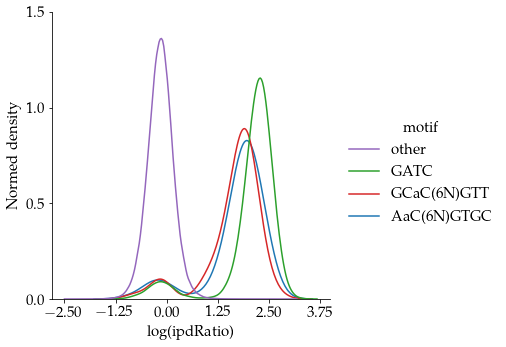

In [59]:
ax = plt.figure(figsize=(10,10))
out = sns.displot(data=df, x="logipdRatio", hue="motif", kind="kde", common_norm=False, palette=palette)
plt.xticks([-2.5,-1.25,0,1.25,2.5,3.75])
plt.yticks([0,0.5,1,1.5])
plt.xlabel("log(ipdRatio)")
plt.ylabel("Normed density")
plt.savefig("ipdratio_distrib.pdf")

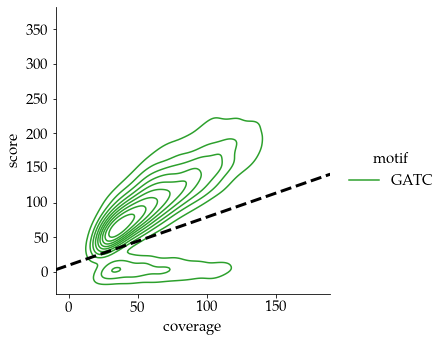

In [60]:
sns.displot(df[(df["motif"]=="GATC")], x="coverage", y="score", hue="motif", kind="kde", palette=palette)
plt.axline((xlinear1,ylinear1), (xlinear2, ylinear2), linewidth=3, color='black',label="proposed threshold",linestyle="--")

In [46]:
from multipy.fdr import abh,lsu,tst,qvalue
from multipy.fwer import bonferroni, holm_bonferroni, hochberg, sidak

In [47]:
from scipy.interpolate import UnivariateSpline


def qvalue(pvals, threshold=0.05, verbose=True):
    """Function for estimating q-values from p-values using the Storey-
    Tibshirani q-value method (2003).

    Input arguments:
    ================
    pvals       - P-values corresponding to a family of hypotheses.
    threshold   - Threshold for deciding which q-values are significant.

    Output arguments:
    =================
    significant - An array of flags indicating which p-values are significant.
    qvals       - Q-values corresponding to the p-values.
    """


    """Count the p-values. Find indices for sorting the p-values into
    ascending order and for reversing the order back to original."""
    m, pvals = len(pvals), np.asarray(pvals)
    ind = np.argsort(pvals)
    rev_ind = np.argsort(ind)
    pvals = pvals[ind]


    # Estimate proportion of features that are truly null.
    kappa = np.arange(0, 0.96, 0.01)
    pik = [sum(pvals > k) / (m*(1-k)) for k in kappa]
    cs = UnivariateSpline(kappa, pik, k=3, s=None, ext=0)
    pi0 = float(cs(1.))
    if (verbose):
        print('The estimated proportion of truly null features is %.3f' % pi0)


    """The smoothing step can sometimes converge outside the interval [0, 1].
    This was noted in the published literature at least by Reiss and
    colleagues [4]. There are at least two approaches one could use to
    attempt to fix the issue:
    (1) Set the estimate to 1 if it is outside the interval, which is the
        assumption in the classic FDR method.
    (2) Assume that if pi0 > 1, it was overestimated, and if pi0 < 0, it
        was underestimated. Set to 0 or 1 depending on which case occurs.

    Here we have chosen the first option, since it is the more conservative
    one of the two.
    """
    if (pi0 < 0 or pi0 > 1):
        pi0 = 1
        print('Smoothing estimator did not converge in [0, 1]')


    # Compute the q-values.
    qvals = np.zeros(np.shape(pvals))
    qvals[-1] = pi0*pvals[-1]
    for i in np.arange(m-2, -1, -1):
        qvals[i] = min(pi0*m*pvals[i]/float(i+1), qvals[i+1])


    # Test which p-values are significant.
    significant = np.zeros(np.shape(pvals), dtype='bool')
    significant[ind] = qvals<threshold


    """Order the q-values according to the original order of the p-values."""
    qvals = qvals[rev_ind]
    return significant, qvals

In [48]:
strategies = {
    "Adaptative Benjamini Krieger Yekutieli":abh,
    "Non-adaptative Benjamini Hocheberg LSU":lsu,
    "Adaptative Two-step LSU":tst,
#     "Adaptative Storey Tibshirani":qvalue,
    "FWER Bonferroni":bonferroni,
    "FWER Holm-Bonferroni":holm_bonferroni,
    "FWER Hochberg":hochberg,
    "FWER Sidak":sidak
}

In [49]:
df["pvalue"].isnull().value_counts()

False    567153
Name: pvalue, dtype: int64

In [50]:
result_df = []

for strategy in strategies:
    print(strategy)
    df[strategy] = strategies[strategy](df["pvalue"].values)
    
    result = {}
    
    for motif in motifs:
        
        tmp = df[df["motif"] == motif].copy()
        
        trues = len(tmp[tmp[strategy] == True])
        falses = len(tmp[tmp[strategy] == False])

        result = {"strategy":strategy,
                     "motif":motif,
                     "H0_rejected":trues,
                     "H0_not_rejected":falses}
        
        result_df.append(result.copy())

out = pd.DataFrame(result_df)
out = out.sort_values(["strategy","motif"],ascending=True)
out

Adaptative Benjamini Krieger Yekutieli
Non-adaptative Benjamini Hocheberg LSU
Adaptative Two-step LSU
FWER Bonferroni
FWER Holm-Bonferroni
FWER Hochberg
FWER Sidak


strategy        motif  H0_rejected  \
1   Adaptative Benjamini Krieger Yekutieli  AaC(6N)GTGC          111   
0   Adaptative Benjamini Krieger Yekutieli         GATC         8898   
2   Adaptative Benjamini Krieger Yekutieli  GCaC(6N)GTT          112   
3   Adaptative Benjamini Krieger Yekutieli        other         1399   
9                  Adaptative Two-step LSU  AaC(6N)GTGC          111   
8                  Adaptative Two-step LSU         GATC         8898   
10                 Adaptative Two-step LSU  GCaC(6N)GTT          112   
11                 Adaptative Two-step LSU        other         1381   
13                         FWER Bonferroni  AaC(6N)GTGC           66   
12                         FWER Bonferroni         GATC         6633   
14                         FWER Bonferroni  GCaC(6N)GTT           56   
15                         FWER Bonferroni        other          170   
21                           FWER Hochberg  AaC(6N)GTGC           66   
20                           FWER Hochberg         GATC         6636   
22                           FWER Hochberg  GCaC(6N)GTT           56   
23                           FWER Hochberg        other          170   
17                    FWER Holm-Bonferroni  AaC(6N)GTGC           66   
16                    FWER Holm-Bonferroni         GATC         6636   
18                    FWER Holm-Bonferroni  GCaC(6N)GTT           56   
19                    FWER Holm-Bonferroni        other          170   
25                              FWER Sidak  AaC(6N)GTGC           66   
24                              FWER Sidak         GATC         6638   
26                              FWER Sidak  GCaC(6N)GTT           56   
27                              FWER Sidak        other          170   
5   Non-adaptative Benjamini Hocheberg LSU  AaC(6N)GTGC          111   
4   Non-adaptative Benjamini Hocheberg LSU         GATC         8898   
6   Non-adaptative Benjamini Hocheberg LSU  GCaC(6N)GTT          112   
7   Non-adaptative Benjamini Hocheberg LSU        other         1399   

    H0_not_rejected  
1                14  
0               758  
2                15  
3            555846  
9                14  
8               758  
10               15  
11           555864  
13               59  
12             3023  
14               71  
15           557075  
21               59  
20             3020  
22               71  
23           557075  
17               59  
16             3020  
18               71  
19           557075  
25               59  
24             3018  
26               71  
27           557075  
5                14  
4               758  
6                15  
7            555846

In [51]:
out.to_csv('FDRcontrol_and_FWER_control_fail.csv')

In [52]:
df["motif"].value_counts()

other          557245
GATC             9656
GCaC(6N)GTT       127
AaC(6N)GTGC       125
Name: motif, dtype: int64

In [51]:
import itertools

In [75]:
df["identificationQv"]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
832449   NaN
832450   NaN
832451   NaN
832452   NaN
832453   NaN
Name: identificationQv, Length: 567153, dtype: float64

In [76]:
df["identificationQv"] = df["identificationQv"].fillna(0)

In [84]:
proto_df = []

list_scores = [20,30,40,50]
list_idqv = [0,20,30,40,50]

for score in list_scores:
    for idqv in list_idqv:
        print(score,idqv)
        
        TP = np.sum(
            (df["score"] >= score) & 
            (df["identificationQv"] >= idqv) &
            (df["motif"].isin(["GATC","GCaC(6N)GTT","AaC(6N)GTGC"]))
        )
        
        
        FP = np.sum(
            (df["score"] >= score) & 
            (df["identificationQv"] >= idqv) &
            (~df["motif"].isin(["GATC","GCaC(6N)GTT","AaC(6N)GTGC"]))
        )

        TN = np.sum(
            (
                (df["score"] < score) | 
                (df["identificationQv"] < idqv)
            ) &
            (~df["motif"].isin(["GATC","GCaC(6N)GTT","AaC(6N)GTGC"]))
        )
        
        FN = np.sum(            
            (
                (df["score"] < score) | 
                (df["identificationQv"] < idqv)
            ) &
            (df["motif"].isin(["GATC","GCaC(6N)GTT","AaC(6N)GTGC"])))
        
        result = {
            "score":score,
            "idqv":idqv,
            "TP":TP,
            "FP":FP,
            "TN":TN,
            "FN":FN
        }
        
        proto_df.append(result.copy())

# Now handling the linear threshold

TP = np.sum(
    (df["isover_linear"] == True) &
    (df["motif"].isin(["GATC","GCaC(6N)GTT","AaC(6N)GTGC"]))
)


FP = np.sum(
    (df["isover_linear"] == True) & 
    (~df["motif"].isin(["GATC","GCaC(6N)GTT","AaC(6N)GTGC"]))
)

TN = np.sum(
    (df["isover_linear"] == False) &
    (~df["motif"].isin(["GATC","GCaC(6N)GTT","AaC(6N)GTGC"]))
)

FN = np.sum(            
    (df["isover_linear"] == False) & 
    (df["motif"].isin(["GATC","GCaC(6N)GTT","AaC(6N)GTGC"])))

result = {
    "score":"over linear threshold",
    "idqv":np.nan,
    "TP":TP,
    "FP":FP,
    "TN":TN,
    "FN":FN
}

proto_df.append(result.copy())
out = pd.DataFrame(proto_df)

out["p"] = out["TP"] + out["FP"]
out["n"] = out["FN"] + out["TN"]
out["Se"] = out["TP"] / (out["TP"] + out["FN"])
out["Sp"] = out["TN"] / (out["TN"] + out["FP"])
out["FDR"] = out["FP"] / out["p"]
out["FNDR"] = out["FN"] / out["n"]
out["total"] = out["p"] + out["n"]

percent_columns = ["Se","Sp","FDR","FNDR"]
for pcolumn in percent_columns:
    out[pcolumn] = [str(round(x*100,2))+" %" for x in out[pcolumn]] 

out

20 0
20 20
20 30
20 40
20 50
30 0
30 20
30 30
30 40
30 50
40 0
40 20
40 30
40 40
40 50
50 0
50 20
50 30
50 40
50 50


score  idqv    TP    FP      TN    FN      p       n  \
0                      20   0.0  9153  5134  552111   755  14287  552866   
1                      20  20.0  8363   652  556593  1545   9015  558138   
2                      20  30.0  7861   373  556872  2047   8234  558919   
3                      20  40.0  7206   248  556997  2702   7454  559699   
4                      20  50.0  6441   178  557067  3467   6619  560534   
5                      30   0.0  9124  1508  555737   784  10632  556521   
6                      30  20.0  8360   504  556741  1548   8864  558289   
7                      30  30.0  7858   325  556920  2050   8183  558970   
8                      30  40.0  7205   230  557015  2703   7435  559718   
9                      30  50.0  6441   172  557073  3467   6613  560540   
10                     40   0.0  8974   670  556575   934   9644  557509   
11                     40  20.0  8307   383  556862  1601   8690  558463   
12                     40  30.0  7839   281  556964  2069   8120  559033   
13                     40  40.0  7198   204  557041  2710   7402  559751   
14                     40  50.0  6439   157  557088  3469   6596  560557   
15                     50   0.0  8558   362  556883  1350   8920  558233   
16                     50  20.0  8074   277  556968  1834   8351  558802   
17                     50  30.0  7698   228  557017  2210   7926  559227   
18                     50  40.0  7145   178  557067  2763   7323  559830   
19                     50  50.0  6421   143  557102  3487   6564  560589   
20  over linear threshold   NaN  9109   379  556866   799   9488  557665   

         Se       Sp      FDR    FNDR   total  
0   92.38 %  99.08 %  35.93 %  0.14 %  567153  
1   84.41 %  99.88 %   7.23 %  0.28 %  567153  
2   79.34 %  99.93 %   4.53 %  0.37 %  567153  
3   72.73 %  99.96 %   3.33 %  0.48 %  567153  
4   65.01 %  99.97 %   2.69 %  0.62 %  567153  
5   92.09 %  99.73 %  14.18 %  0.14 %  567153  
6   84.38 %  99.91 %   5.69 %  0.28 %  567153  
7   79.31 %  99.94 %   3.97 %  0.37 %  567153  
8   72.72 %  99.96 %   3.09 %  0.48 %  567153  
9   65.01 %  99.97 %    2.6 %  0.62 %  567153  
10  90.57 %  99.88 %   6.95 %  0.17 %  567153  
11  83.84 %  99.93 %   4.41 %  0.29 %  567153  
12  79.12 %  99.95 %   3.46 %  0.37 %  567153  
13  72.65 %  99.96 %   2.76 %  0.48 %  567153  
14  64.99 %  99.97 %   2.38 %  0.62 %  567153  
15  86.37 %  99.94 %   4.06 %  0.24 %  567153  
16  81.49 %  99.95 %   3.32 %  0.33 %  567153  
17  77.69 %  99.96 %   2.88 %   0.4 %  567153  
18  72.11 %  99.97 %   2.43 %  0.49 %  567153  
19  64.81 %  99.97 %   2.18 %  0.62 %  567153  
20  91.94 %  99.93 %   3.99 %  0.14 %  567153

In [85]:
out.to_csv("se_sp.csv")

In [ ]:
# GATC stats now !

In [90]:
tqdm.pandas()

In [ ]:
# We create a unique identifier for each GATC site

In [398]:
def reverse_strand(strand):
    if strand == 1:
        return 0
    else:
        return 1

def create_site_identifier(experiment,holeid,tpl,strand):
    if strand == 0:
        return str(experiment)+"_"+str(holeid)+"_"+str(tpl)+'_'+str(int(strand))
    else:
        return str(experiment)+"_"+str(holeid)+"_"+str(tpl-1)+'_'+str(int(reverse_strand(strand)))


In [399]:
GATCs = df[(df["isin_GATC"] == True) & (df["base"] == "A")].copy()

In [400]:
GATCs["GATC_identifier"] = [create_site_identifier(w,x,y,z) for (w,x,y,z) in zip(
    GATCs["experiment"],GATCs["HoleID"],GATCs["tpl"],GATCs["strand"]
)]

In [401]:
len(GATCs)

9656

In [402]:
len(GATCs["GATC_identifier"].unique())

4892

In [403]:
counts = GATCs.groupby(["GATC_identifier"]).apply(lambda x: len(x["GATC_identifier"]))
counts

GATC_identifier
HT2_21365366_3822513_0     2
HTVEG_10027766_368651_0    2
HTVEG_10027766_368827_0    2
HTVEG_10027766_368935_0    2
HTVEG_10092958_346533_0    2
                          ..
NM910_9241000_44457_0      2
NM910_9765418_10894_0      2
NM910_9961659_2575469_0    2
NM910_9961659_2575598_0    2
NM910_9961659_2575628_0    2
Length: 4892, dtype: int64

In [404]:
pd.DataFrame(counts)[0].value_counts()

2    4764
1     128
Name: 0, dtype: int64

In [405]:
# Let's remove the adenines without a partner :

In [406]:
counts = dict(counts)
counts

{'HT2_21365366_3822513_0': 2,
 'HTVEG_10027766_368651_0': 2,
 'HTVEG_10027766_368827_0': 2,
 'HTVEG_10027766_368935_0': 2,
 'HTVEG_10092958_346533_0': 2,
 'HTVEG_10420536_2527276_0': 2,
 'HTVEG_10486376_84388_0': 2,
 'HTVEG_10486376_84474_0': 2,
 'HTVEG_10486376_84584_0': 2,
 'HTVEG_10617072_2007519_0': 2,
 'HTVEG_10617072_2007612_0': 2,
 'HTVEG_10682537_2884151_0': 2,
 'HTVEG_10682537_2884276_0': 2,
 'HTVEG_10682537_2884301_0': 2,
 'HTVEG_10682941_2981462_0': 2,
 'HTVEG_10682941_2981480_0': 2,
 'HTVEG_11010224_589633_0': 2,
 'HTVEG_11010224_589716_0': 2,
 'HTVEG_11075821_4088691_0': 2,
 'HTVEG_11075821_4088706_0': 2,
 'HTVEG_11075821_4088928_0': 2,
 'HTVEG_11141902_1056685_0': 2,
 'HTVEG_11206729_191917_0': 2,
 'HTVEG_11206729_192207_0': 2,
 'HTVEG_11403337_2680399_0': 2,
 'HTVEG_11403337_2680408_0': 2,
 'HTVEG_11403337_2680570_0': 2,
 'HTVEG_11403337_2680611_0': 2,
 'HTVEG_11403337_2680734_0': 2,
 'HTVEG_11403879_69865_0': 2,
 'HTVEG_11403879_69940_0': 2,
 'HTVEG_11469801_2319921_0':

In [407]:
GATCs["adenines_persite"] = [counts[x] for x in GATCs["GATC_identifier"]]

In [408]:
GATCs["adenines_persite"].value_counts()

2    9528
1     128
Name: adenines_persite, dtype: int64

In [409]:
GATCs = GATCs[GATCs["adenines_persite"] == 2]
len(GATCs)

9528

In [410]:
GATCs[["tpl","experiment","HoleID","strand","GATC_identifier","coverage"]]

tpl experiment    HoleID  strand           GATC_identifier  \
212     3822513        HT2  21365366     0.0    HT2_21365366_3822513_0   
213     3822514        HT2  21365366     1.0    HT2_21365366_3822513_0   
5069     401194      HTVEG   4260642     0.0    HTVEG_4260642_401194_0   
5070     401195      HTVEG   4260642     1.0    HTVEG_4260642_401194_0   
9282    4247120      HTVEG   4719067     0.0   HTVEG_4719067_4247120_0   
...         ...        ...       ...     ...                       ...   
832683   113672      NM910  72745557     1.0   NM910_72745557_113671_0   
832296  2413638      NM910  73859731     0.0  NM910_73859731_2413638_0   
832297  2413639      NM910  73859731     1.0  NM910_73859731_2413638_0   
832345  2413761      NM910  73859731     0.0  NM910_73859731_2413761_0   
832346  2413762      NM910  73859731     1.0  NM910_73859731_2413761_0   

        coverage  
212         51.0  
213         50.0  
5069        36.0  
5070        37.0  
9282        25.0  
...          ...  
832683     119.0  
832296     120.0  
832297     128.0  
832345     120.0  
832346     124.0  

[9528 rows x 6 columns]

In [411]:
GATCs_0 = GATCs[GATCs["strand"] == 0].copy()[["motif","coverage","score","identificationQv","isover_linear","GATC_identifier"]]
GATCs_1 = GATCs[GATCs["strand"] == 1].copy()[["motif","coverage","score","identificationQv","isover_linear","GATC_identifier"]]

In [412]:
GATCs_0 = GATCs_0.reset_index()
columns = list(GATCs_0)
columns.remove("GATC_identifier")
for column in columns:
    GATCs_0[column+"_0"] = GATCs_0[column]
    del GATCs_0[column]
GATCs_0

GATC_identifier  index_0 motif_0  coverage_0  score_0  \
0       HT2_21365366_3822513_0      212    GATC        51.0     86.0   
1       HTVEG_4260642_401194_0     5069    GATC        36.0      4.0   
2      HTVEG_4719067_4247120_0     9282    GATC        25.0     35.0   
3        HTVEG_4980986_36512_0    12350    GATC        96.0    114.0   
4       HTVEG_4981112_338898_0     6406    GATC        54.0    124.0   
...                        ...      ...     ...         ...      ...   
4759   NM910_71893594_461028_0   832264    GATC       126.0    126.0   
4760   NM910_71893594_461073_0   832283    GATC        90.0      0.0   
4761   NM910_72745557_113671_0   832682    GATC       119.0    134.0   
4762  NM910_73859731_2413638_0   832296    GATC       120.0    167.0   
4763  NM910_73859731_2413761_0   832345    GATC       120.0    150.0   

      identificationQv_0  isover_linear_0  
0                   54.0             True  
1                    0.0            False  
2                   26.0             True  
3                   95.0             True  
4                   97.0             True  
...                  ...              ...  
4759               101.0             True  
4760                 0.0            False  
4761                79.0             True  
4762               158.0             True  
4763               163.0             True  

[4764 rows x 7 columns]

In [413]:
GATCs_1 = GATCs_1.reset_index()
columns = list(GATCs_1)
columns.remove("GATC_identifier")
for column in columns:
    GATCs_1[column+"_1"] = GATCs_1[column].copy()
    del GATCs_1[column]
GATCs_1

GATC_identifier  index_1 motif_1  coverage_1  score_1  \
0       HT2_21365366_3822513_0      213    GATC        50.0     82.0   
1       HTVEG_4260642_401194_0     5070    GATC        37.0     86.0   
2      HTVEG_4719067_4247120_0     9283    GATC        26.0     58.0   
3        HTVEG_4980986_36512_0    12351    GATC        93.0    127.0   
4       HTVEG_4981112_338898_0     6407    GATC        56.0     13.0   
...                        ...      ...     ...         ...      ...   
4759   NM910_71893594_461028_0   832265    GATC       123.0    166.0   
4760   NM910_71893594_461073_0   832284    GATC        86.0    121.0   
4761   NM910_72745557_113671_0   832683    GATC       119.0    161.0   
4762  NM910_73859731_2413638_0   832297    GATC       128.0    175.0   
4763  NM910_73859731_2413761_0   832346    GATC       124.0    204.0   

      identificationQv_1  isover_linear_1  
0                   63.0             True  
1                  112.0             True  
2                   29.0             True  
3                  115.0             True  
4                    0.0            False  
...                  ...              ...  
4759               135.0             True  
4760                56.0             True  
4761               156.0             True  
4762               171.0             True  
4763               187.0             True  

[4764 rows x 7 columns]

In [414]:
GATC_sites = pd.merge(GATCs_0,GATCs_1,on="GATC_identifier")
GATC_sites

GATC_identifier  index_0 motif_0  coverage_0  score_0  \
0       HT2_21365366_3822513_0      212    GATC        51.0     86.0   
1       HTVEG_4260642_401194_0     5069    GATC        36.0      4.0   
2      HTVEG_4719067_4247120_0     9282    GATC        25.0     35.0   
3        HTVEG_4980986_36512_0    12350    GATC        96.0    114.0   
4       HTVEG_4981112_338898_0     6406    GATC        54.0    124.0   
...                        ...      ...     ...         ...      ...   
4759   NM910_71893594_461028_0   832264    GATC       126.0    126.0   
4760   NM910_71893594_461073_0   832283    GATC        90.0      0.0   
4761   NM910_72745557_113671_0   832682    GATC       119.0    134.0   
4762  NM910_73859731_2413638_0   832296    GATC       120.0    167.0   
4763  NM910_73859731_2413761_0   832345    GATC       120.0    150.0   

      identificationQv_0  isover_linear_0  index_1 motif_1  coverage_1  \
0                   54.0             True      213    GATC        50.0   
1                    0.0            False     5070    GATC        37.0   
2                   26.0             True     9283    GATC        26.0   
3                   95.0             True    12351    GATC        93.0   
4                   97.0             True     6407    GATC        56.0   
...                  ...              ...      ...     ...         ...   
4759               101.0             True   832265    GATC       123.0   
4760                 0.0            False   832284    GATC        86.0   
4761                79.0             True   832683    GATC       119.0   
4762               158.0             True   832297    GATC       128.0   
4763               163.0             True   832346    GATC       124.0   

      score_1  identificationQv_1  isover_linear_1  
0        82.0                63.0             True  
1        86.0               112.0             True  
2        58.0                29.0             True  
3       127.0               115.0             True  
4        13.0                 0.0            False  
...       ...                 ...              ...  
4759    166.0               135.0             True  
4760    121.0                56.0             True  
4761    161.0               156.0             True  
4762    175.0               171.0             True  
4763    204.0               187.0             True  

[4764 rows x 13 columns]

In [415]:
GATC_sites

GATC_identifier  index_0 motif_0  coverage_0  score_0  \
0       HT2_21365366_3822513_0      212    GATC        51.0     86.0   
1       HTVEG_4260642_401194_0     5069    GATC        36.0      4.0   
2      HTVEG_4719067_4247120_0     9282    GATC        25.0     35.0   
3        HTVEG_4980986_36512_0    12350    GATC        96.0    114.0   
4       HTVEG_4981112_338898_0     6406    GATC        54.0    124.0   
...                        ...      ...     ...         ...      ...   
4759   NM910_71893594_461028_0   832264    GATC       126.0    126.0   
4760   NM910_71893594_461073_0   832283    GATC        90.0      0.0   
4761   NM910_72745557_113671_0   832682    GATC       119.0    134.0   
4762  NM910_73859731_2413638_0   832296    GATC       120.0    167.0   
4763  NM910_73859731_2413761_0   832345    GATC       120.0    150.0   

      identificationQv_0  isover_linear_0  index_1 motif_1  coverage_1  \
0                   54.0             True      213    GATC        50.0   
1                    0.0            False     5070    GATC        37.0   
2                   26.0             True     9283    GATC        26.0   
3                   95.0             True    12351    GATC        93.0   
4                   97.0             True     6407    GATC        56.0   
...                  ...              ...      ...     ...         ...   
4759               101.0             True   832265    GATC       123.0   
4760                 0.0            False   832284    GATC        86.0   
4761                79.0             True   832683    GATC       119.0   
4762               158.0             True   832297    GATC       128.0   
4763               163.0             True   832346    GATC       124.0   

      score_1  identificationQv_1  isover_linear_1  
0        82.0                63.0             True  
1        86.0               112.0             True  
2        58.0                29.0             True  
3       127.0               115.0             True  
4        13.0                 0.0            False  
...       ...                 ...              ...  
4759    166.0               135.0             True  
4760    121.0                56.0             True  
4761    161.0               156.0             True  
4762    175.0               171.0             True  
4763    204.0               187.0             True  

[4764 rows x 13 columns]

In [419]:
proto_df = []

list_scores = [20,30,40,50]
list_idqv = [0,20,30,40,50]

for score in list_scores:
    for idqv in list_idqv:
        
        result = {}
        result = {
            "score":score,
            "identificationQv":idqv,
        }
        
        GATC_sites["modified_0"] = (GATC_sites["score_0"] >= score) & (GATC_sites["identificationQv_0"] >= idqv)
        GATC_sites["modified_1"] = (GATC_sites["score_1"] >= score) & (GATC_sites["identificationQv_1"] >= idqv)
        GATC_sites["nbmodified"] = GATC_sites["modified_0"].astype(int) + GATC_sites["modified_1"].astype(int)
        
        counts = GATC_sites["nbmodified"].value_counts()
        
        for i in [0,1,2]:
            try:
                result["nb_"+str(i)] = counts[i]
            except KeyError:
                result["nb_"+str(i)] = np.nan
                
        proto_df.append(result.copy())

        
# Same with the linear threshold now

result = {}
result = {
    "score":"> linear",
    "identificationQv":np.nan,
}

GATC_sites["modified_0"] = (GATC_sites["isover_linear_0"]) 
GATC_sites["modified_1"] = (GATC_sites["isover_linear_1"]) 
GATC_sites["nbmodified"] = GATC_sites["modified_0"].astype(int) + GATC_sites["modified_1"].astype(int)

counts = GATC_sites["nbmodified"].value_counts()

for i in [0,1,2]:
    try:
        result["nb_"+str(i)] = counts[i]
    except KeyError:
        result["nb_"+str(i)] = np.nan

proto_df.append(result.copy())
        
out = pd.DataFrame(proto_df)
out           

score  identificationQv  nb_0  nb_1  nb_2
0         20               0.0    69   555  4140
1         20              20.0   225   952  3587
2         20              30.0   355  1149  3260
3         20              40.0   600  1278  2886
4         20              50.0   916  1366  2482
5         30               0.0    73   570  4121
6         30              20.0   226   952  3586
7         30              30.0   356  1149  3259
8         30              40.0   600  1279  2885
9         30              50.0   916  1366  2482
10        40               0.0    97   640  4027
11        40              20.0   246   956  3562
12        40              30.0   366  1146  3252
13        40              40.0   603  1279  2882
14        40              50.0   917  1366  2481
15        50               0.0   194   812  3758
16        50              20.0   326  1006  3432
17        50              30.0   434  1145  3185
18        50              40.0   634  1268  2862
19        50              50.0   928  1361  2475
20  > linear               NaN    73   577  4114

In [420]:
out["total"] = out['nb_0'] + out['nb_1'] + out['nb_2']

In [421]:
out

score  identificationQv  nb_0  nb_1  nb_2  total
0         20               0.0    69   555  4140   4764
1         20              20.0   225   952  3587   4764
2         20              30.0   355  1149  3260   4764
3         20              40.0   600  1278  2886   4764
4         20              50.0   916  1366  2482   4764
5         30               0.0    73   570  4121   4764
6         30              20.0   226   952  3586   4764
7         30              30.0   356  1149  3259   4764
8         30              40.0   600  1279  2885   4764
9         30              50.0   916  1366  2482   4764
10        40               0.0    97   640  4027   4764
11        40              20.0   246   956  3562   4764
12        40              30.0   366  1146  3252   4764
13        40              40.0   603  1279  2882   4764
14        40              50.0   917  1366  2481   4764
15        50               0.0   194   812  3758   4764
16        50              20.0   326  1006  3432   4764
17        50              30.0   434  1145  3185   4764
18        50              40.0   634  1268  2862   4764
19        50              50.0   928  1361  2475   4764
20  > linear               NaN    73   577  4114   4764

In [428]:
out["det. non-methylated"] = out["nb_0"] / out["total"]
out["det. hemi-methylated"] = out["nb_1"] / out["total"]
out["det. sym-methylated"] = out["nb_2"] / out["total"]

totransform = ["det. non-methylated","det. hemi-methylated","det. sym-methylated"]

for x in totransform:
    out[x] = [str(round(y*100,2))+" %" for y in out[x]]

out

score  identificationQv  nb_0  nb_1  nb_2  total det. non-methylated  \
0         20               0.0    69   555  4140   4764              1.45 %   
1         20              20.0   225   952  3587   4764              4.72 %   
2         20              30.0   355  1149  3260   4764              7.45 %   
3         20              40.0   600  1278  2886   4764             12.59 %   
4         20              50.0   916  1366  2482   4764             19.23 %   
5         30               0.0    73   570  4121   4764              1.53 %   
6         30              20.0   226   952  3586   4764              4.74 %   
7         30              30.0   356  1149  3259   4764              7.47 %   
8         30              40.0   600  1279  2885   4764             12.59 %   
9         30              50.0   916  1366  2482   4764             19.23 %   
10        40               0.0    97   640  4027   4764              2.04 %   
11        40              20.0   246   956  3562   4764              5.16 %   
12        40              30.0   366  1146  3252   4764              7.68 %   
13        40              40.0   603  1279  2882   4764             12.66 %   
14        40              50.0   917  1366  2481   4764             19.25 %   
15        50               0.0   194   812  3758   4764              4.07 %   
16        50              20.0   326  1006  3432   4764              6.84 %   
17        50              30.0   434  1145  3185   4764              9.11 %   
18        50              40.0   634  1268  2862   4764             13.31 %   
19        50              50.0   928  1361  2475   4764             19.48 %   
20  > linear               NaN    73   577  4114   4764              1.53 %   

   det. hemi-methylated det. sym-methylated  
0               11.65 %              86.9 %  
1               19.98 %             75.29 %  
2               24.12 %             68.43 %  
3               26.83 %             60.58 %  
4               28.67 %              52.1 %  
5               11.96 %              86.5 %  
6               19.98 %             75.27 %  
7               24.12 %             68.41 %  
8               26.85 %             60.56 %  
9               28.67 %              52.1 %  
10              13.43 %             84.53 %  
11              20.07 %             74.77 %  
12              24.06 %             68.26 %  
13              26.85 %              60.5 %  
14              28.67 %             52.08 %  
15              17.04 %             78.88 %  
16              21.12 %             72.04 %  
17              24.03 %             66.86 %  
18              26.62 %             60.08 %  
19              28.57 %             51.95 %  
20              12.11 %             86.36 %

In [429]:
out.to_csv('GATC_stats.csv')

In [467]:
counts = df["coverage"].astype(int).value_counts()
counts = pd.DataFrame(counts)
counts["count"] = counts["coverage"]
counts["coverage"] = [x for x in counts.index.values]
counts = counts.sort_values(["coverage"])
counts

coverage  count
25         25  10582
26         26  10127
27         27   8739
28         28   7774
29         29   7737
..        ...    ...
173       173     48
174       174     56
175       175     29
176       176     15
177       177      6

[153 rows x 2 columns]

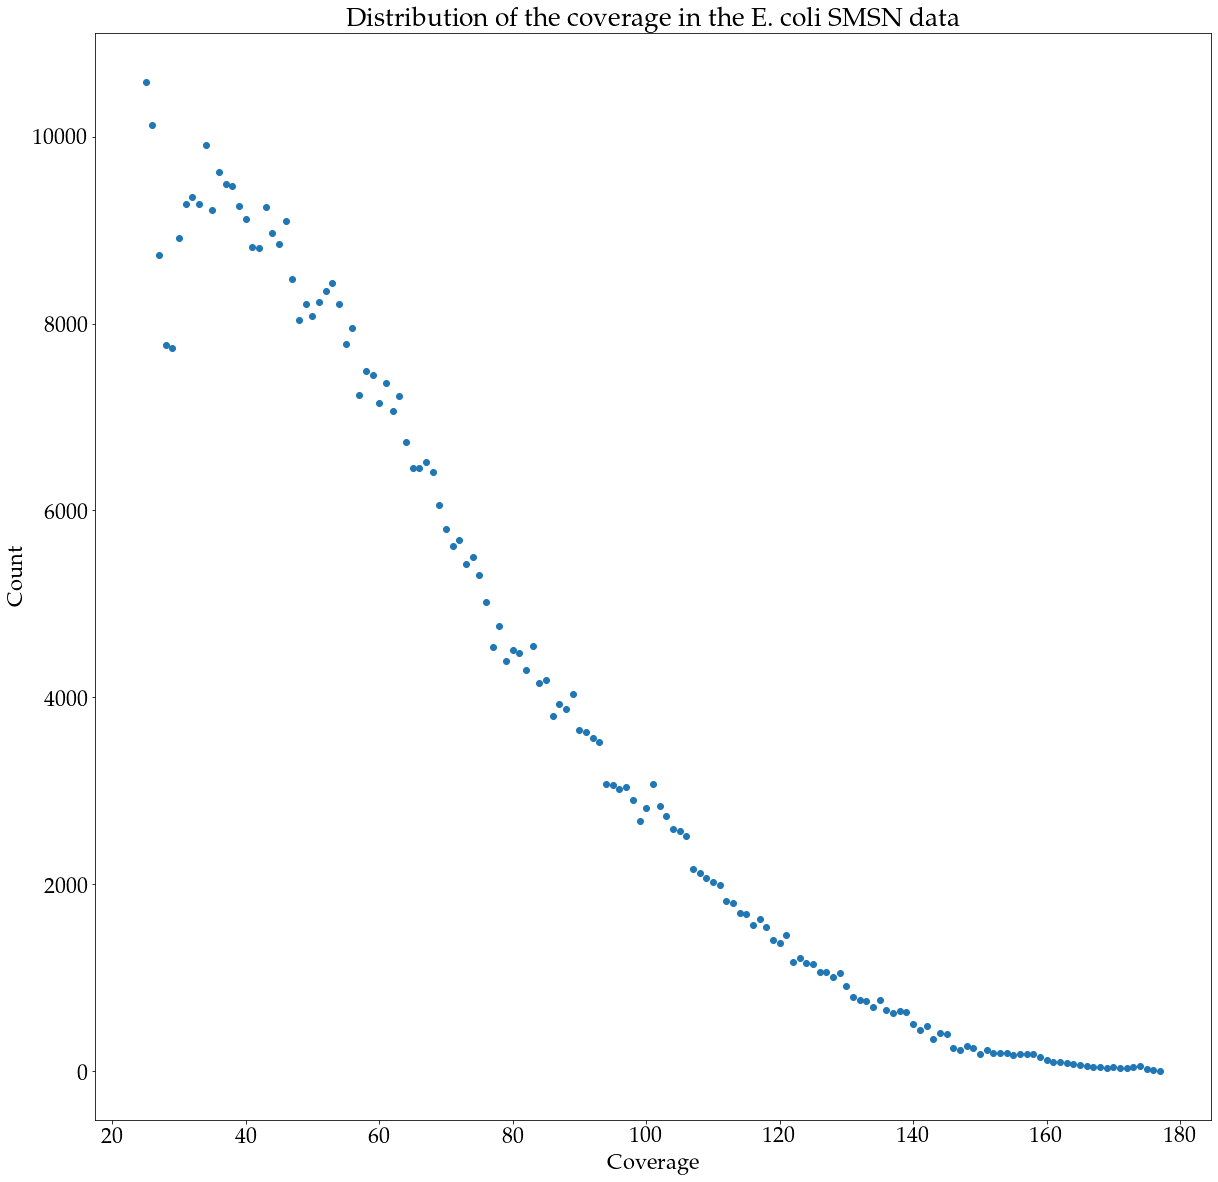

In [472]:
plt.scatter(counts["coverage"],counts["count"])
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.title("Distribution of the coverage in the E. coli SMSN data")
plt.savefig("coverage_distribution.pdf")

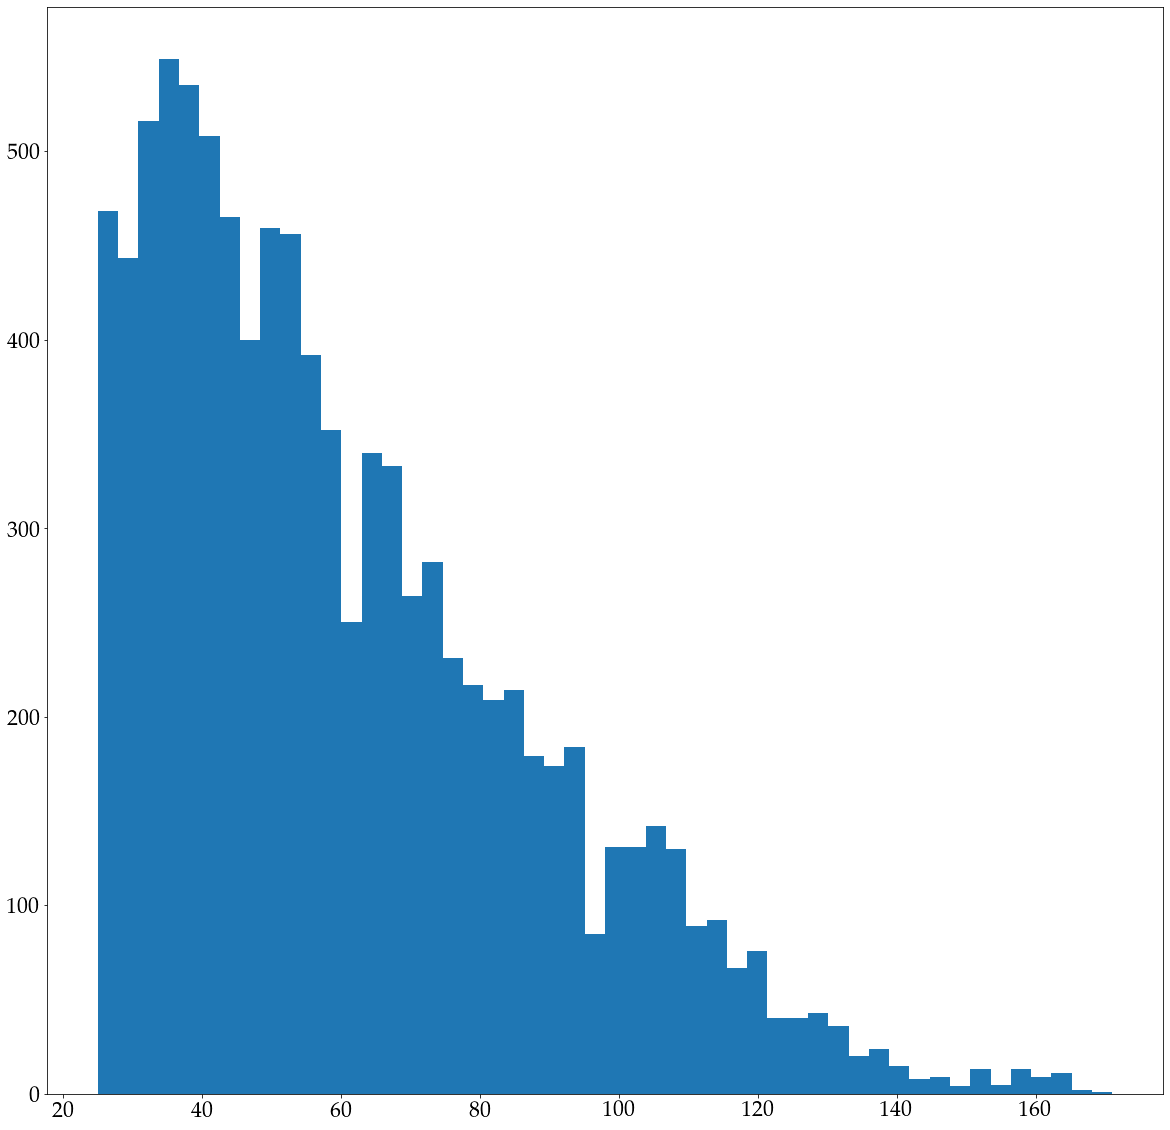

In [481]:
_ = plt.hist(df[df["motif"] == "GATC"]["coverage"],bins=50)

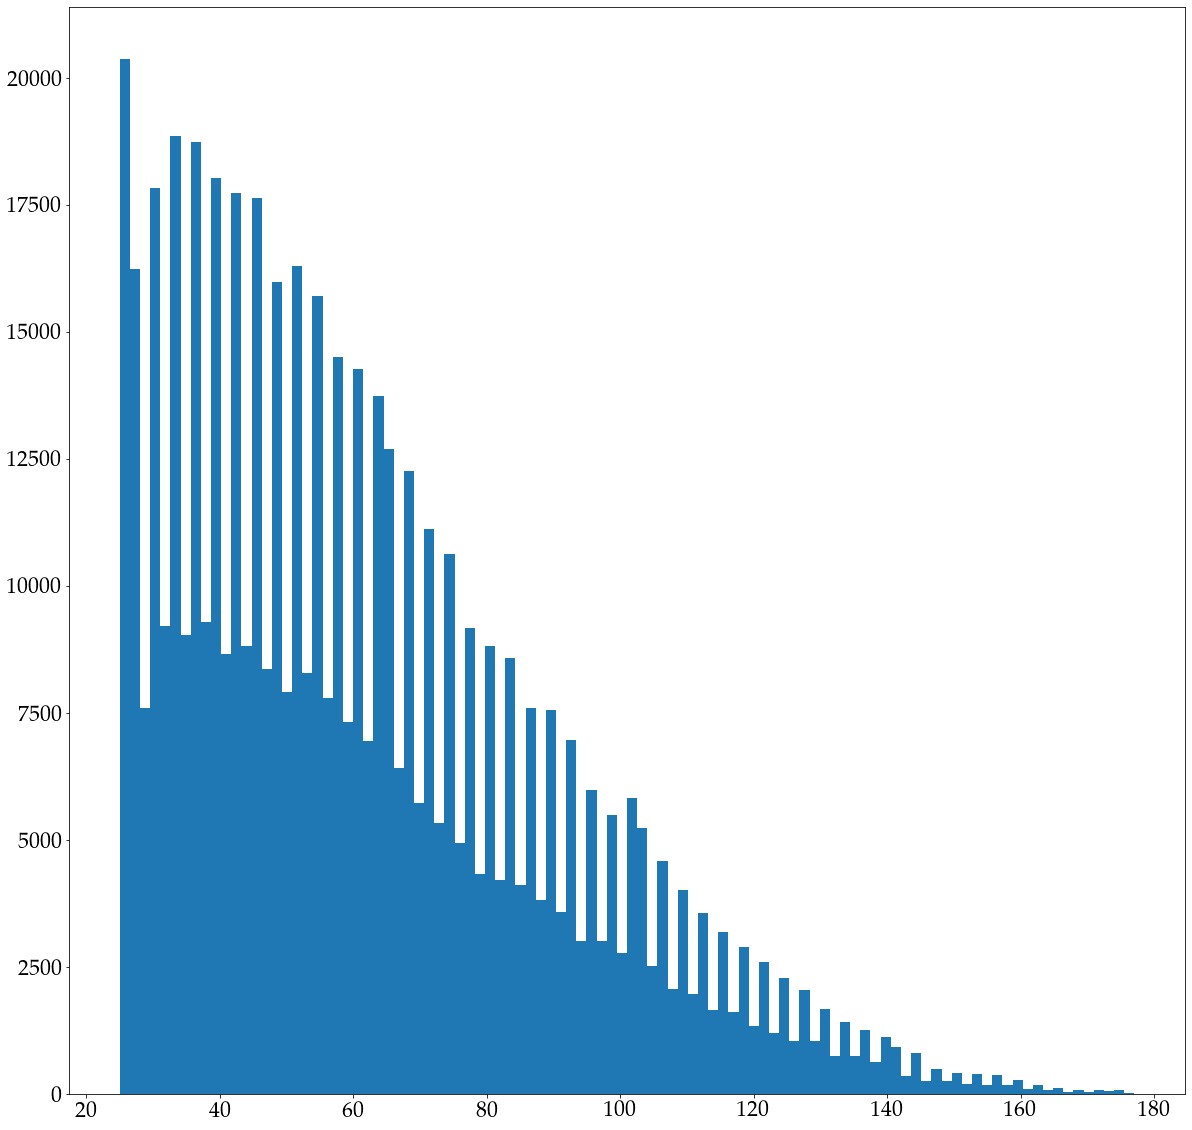

In [483]:
_ = plt.hist(df[df["motif"] != "GATC"]["coverage"],bins=100)

In [449]:
list_coverages = [x for x in range(min(counts),max(counts+1))]
counts = dict(counts)
counts

list_counts = []
for x in list_coverages:
    try:
        count = counts[x]
    except KeyError:
        count = 0
    list_counts.append(count)

In [450]:
list_counts

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10582,
 10127,
 8739,
 7774,
 7737,
 8911,
 9281,
 9352,
 9284,
 9915,
 9217,
 9626,
 9499,
 9474,
 9257,
 9119,
 8824,
 8810,
 9243,
 8972,
 8848,
 9099,
 8481,
 8042,
 8208,
 8076,
 8230,
 8345,
 8437,
 8208,
 7785,
 7948,
 7236,
 7498,
 7449,
 7149,
 7362,
 7064,
 7225,
 6730,
 6459,
 6452,
 6524,
 6408,
 6056,
 5804,
 5625,
 5680,
 5423,
 5502,
 5307,
 5025,
 4544,
 4769,
 4392,
 4502,
 4479,
 4288,
 4547,
 4158,
 4181,
 3802,
 3929,
 3876,
 4035,
 3652,
 3633,
 3566,
 3524,
 3072,
 3068,
 3020,
 3041,
 2907,
 2676,
 2813,
 3077,
 2836,
 2726,
 2595,
 2575,
 2517,
 2159,
 2119,
 2069,
 2022,
 1997,
 1822,
 1803,
 1689,
 1683,
 1567,
 1631,
 1538,
 1399,
 1376,
 1453,
 1164,
 1215,
 1155,
 1147,
 1062,
 1065,
 1007,
 1054,
 908,
 795,
 767,
 755,
 691,
 757,
 656,
 621,
 641,
 629,
 507,
 444,
 481,
 346,
 414,
 402,
 251,
 230,
 271,
 247,
 183,
 232,
 195,
 197,
 196,
 173,
 182,
 189,
 185,
 154,
 124,
 